# Marketing Analysis

Задача включала в себя определение оптимального срока оценки окупаемости кампаний, выявление наиболее успешных рекламных кампаний, типов кампаний и рекламных сетей, расчет накопительного ARPU и фактического CPI, а также предложение дополнительных метрик для оценки успешности кампаний на ранних стадиях.

In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [434]:
# Загрузка данных
registrations = pd.read_csv("C:/Users/HP/Desktop/df/registrations.csv", parse_dates=['created_date'])
payments = pd.read_csv("C:/Users/HP/Desktop/df/payments.csv", parse_dates=['payment_date'])
persents = pd.read_csv("C:/Users/HP/Desktop/df/persents.csv")

ad_budget = pd.read_excel("C:/Users/HP/Desktop/df/advertising_budget.xlsx")

In [435]:
# объединение двух DataFrame(registrations и payments)
merged_data = pd.merge(registrations, payments, on='account_id')
merged_data.head()

,Unnamed: 0,account_id,created_date,campaign,payment_date,Payment_types,real_cost
0,53,3842433.0,2021-01-01,NaN,2021-01-05 16:43:29,Payment_system_4,0.090
1,308,3842688.0,2021-01-01,NaN,2021-08-28 03:00:07,Payment_system_4,0.350
2,308,3842688.0,2021-01-01,NaN,2021-08-28 03:09:02,Payment_system_5,6.170
3,308,3842688.0,2021-01-01,NaN,2021-08-28 03:20:54,Payment_system_4,0.350
4,308,3842688.0,2021-01-01,NaN,2021-09-24 16:57:53,Payment_system_5,26.199


#### 1.	Определение оптимального срока оценки окупаемости рекламных кампаний.

In [414]:
# Рассчитываем оптимальный период для оценки окупаемости
merged_data['time_to_first_payment'] = (merged_data['payment_date'] - merged_data['created_date']).dt.days
optimal_period = merged_data['time_to_first_payment'].quantile(0.75)
print(f'Оптимальный период для оценки окупаемости: {optimal_period} дней')

Оптимальный период для оценки окупаемости: 199.25 дней


Видим результат, что примерно 75% пользователей, зарегистрировавшихся с помощью рекламных кампаний, совершают первый платеж в течение этого периода или ранее.
Таким образом, для анализа эффективности рекламных кампаний и их окупаемости рекомендуется оценить результаты в течение примерно 199 дней после регистрации пользователей.

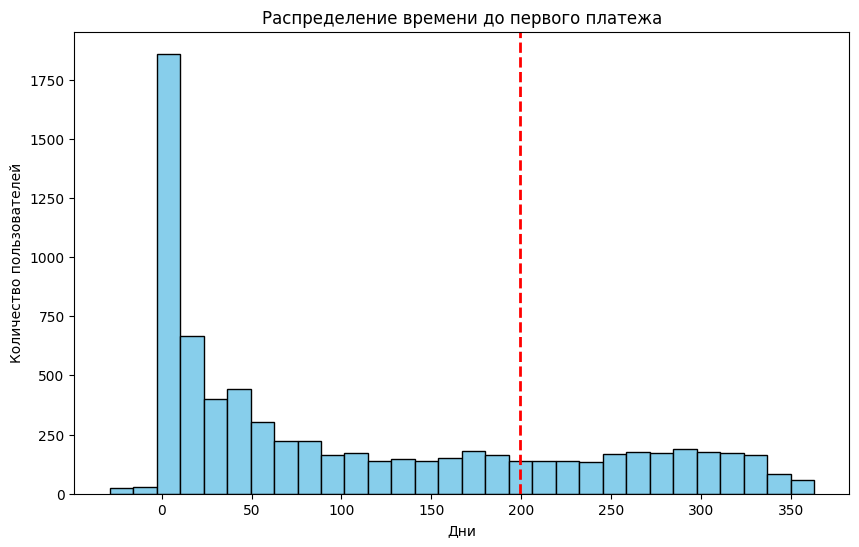

In [415]:
# Визуализация 
plt.figure(figsize=(10, 6))
plt.hist(merged_data['time_to_first_payment'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(optimal_period, color='red', linestyle='dashed', linewidth=2)
plt.title('Распределение времени до первого платежа')
plt.xlabel('Дни')
plt.ylabel('Количество пользователей')
plt.show()

#### 2. Определение наиболее успешные:
●	Рекламные кампании \
●	Тип рекламных кампаний\
●	Рекламную сеть

In [422]:
# Сортировка и вывод
campaign_payments = merged_data.groupby("campaign").size().reset_index(name="payments_count")
campaign_type_payments = ad_budget.groupby("Campaign_type")["Spend, USD"].sum().reset_index(name="total_spend")
network_spend = ad_budget.groupby("media_source")["Spend, USD"].sum().reset_index(name="total_spend")

campaign_payments = campaign_payments.sort_values(by="payments_count", ascending=False)
campaign_type_payments = campaign_type_payments.sort_values(by="total_spend", ascending=False)
network_spend = network_spend.sort_values(by="total_spend", ascending=False)

print("\nНаиболее успешные рекламные кампании:")
print(campaign_payments)
print("\nНаиболее успешные типы рекламных кампаний:")
print(campaign_type_payments)
print("\nНаиболее успешная рекламная сеть:")
print(network_spend)


Наиболее успешные рекламные кампании:
            campaign  payments_count
6   RUS_MS1_purchase             196
5    RUS_MS1_install             188
0    BRA_MS1_install             105
8   UKR_MS1_purchase              79
7    UKR_MS1_install              52
1   BRA_MS1_purchase              50
4  PR_youtube_bloger              23
3    ENG_MS2_install              10
2    BRA_MS2_install               8

Наиболее успешные типы рекламных кампаний:
  Campaign_type  total_spend
1      purchase      1363.57
0       install       625.95

Наиболее успешная рекламная сеть:
     media_source  total_spend
0  Media_source_1        99.12
1  Media_source_2        81.15


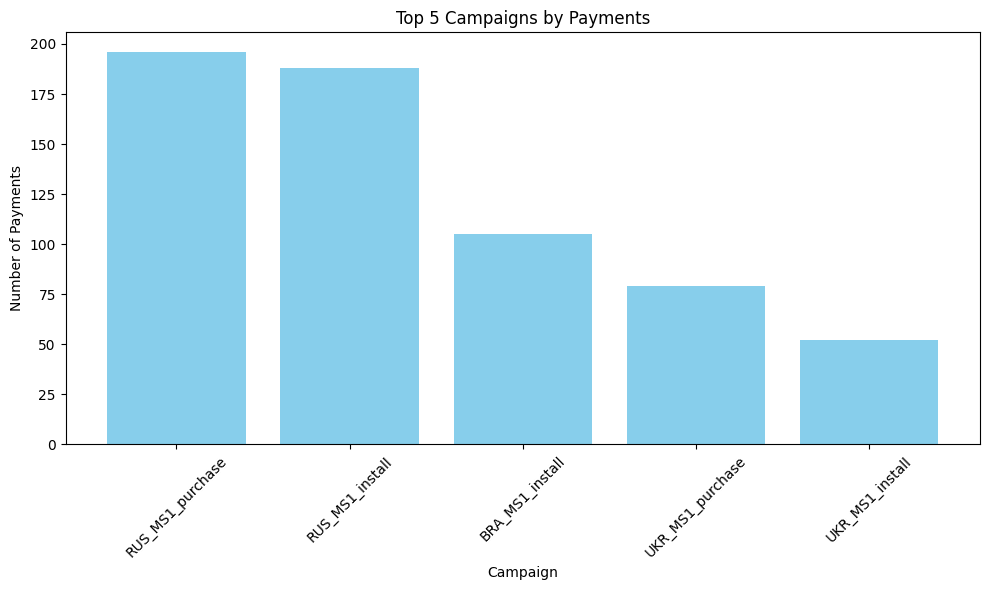

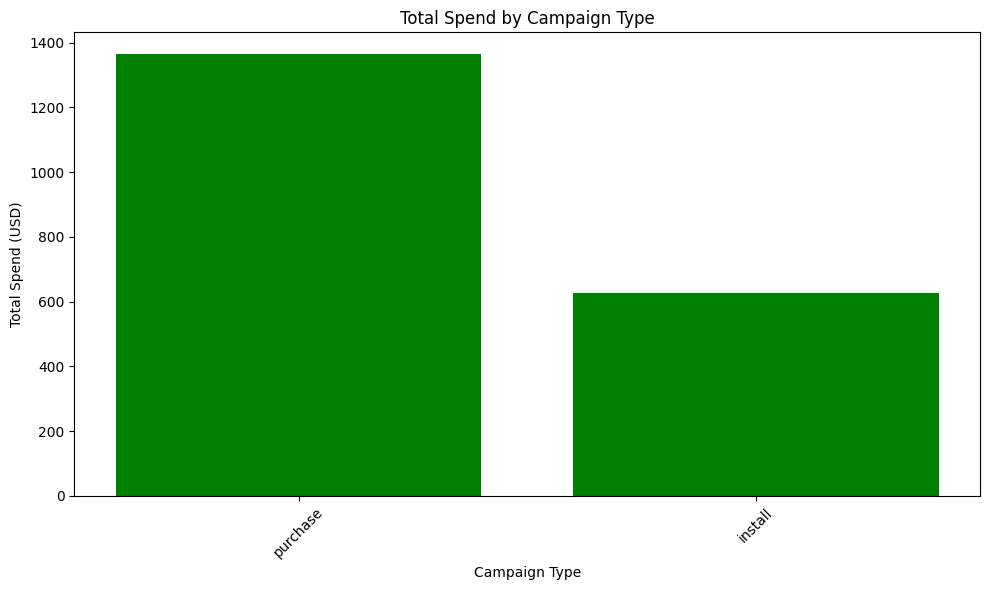

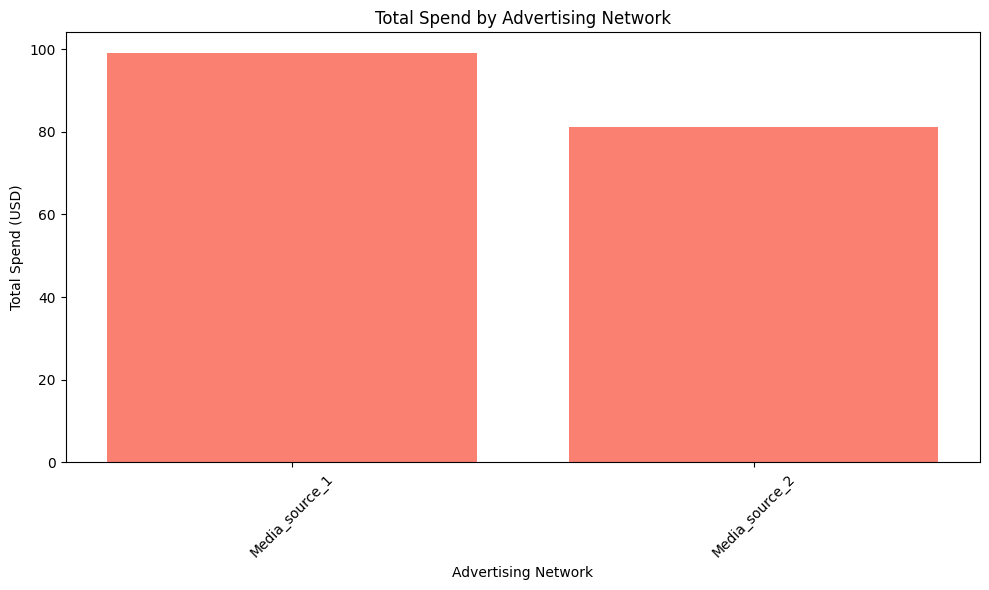

In [425]:
# Визуализация
plt.figure(figsize=(10, 6))
plt.bar(campaign_payments["campaign"][:5], campaign_payments["payments_count"][:5], color='skyblue')
plt.title("Top 5 Campaigns by Payments")
plt.xlabel("Campaign")
plt.ylabel("Number of Payments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(campaign_type_payments["Campaign_type"], campaign_type_payments["total_spend"], color='green')
plt.title("Total Spend by Campaign Type")
plt.xlabel("Campaign Type")
plt.ylabel("Total Spend (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(network_spend["media_source"], network_spend["total_spend"], color='salmon')
plt.title("Total Spend by Advertising Network")
plt.xlabel("Advertising Network")
plt.ylabel("Total Spend (USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 3.	Рассчитывание накопительный ARPU 
ARPU (Average Revenue Per User) - это метрика, которая измеряет среднюю выручку, приходящуюся на одного пользователя.

In [318]:
def calculate_arpu(data, days):
    # Фильтрация данных по заданному количеству дней
    filtered_data = data[data['payment_date'] - data['created_date'] <= pd.Timedelta(days=days)]
    # Расчет суммы платежей и количества уникальных пользователей
    total_revenue = filtered_data['real_cost'].sum()
    unique_users = filtered_data['account_id'].nunique()
    arpu = total_revenue / unique_users
    return arpu
arpu_7 = calculate_arpu(merged_data, 7)
arpu_14 = calculate_arpu(merged_data, 14)
arpu_30 = calculate_arpu(merged_data, 30)
print("ARPU за 7 дней:", arpu_7)
print("ARPU за 14 дней:", arpu_14)
print("ARPU за 30 дней:", arpu_30)

ARPU за 7 дней: 9.71517338990333
ARPU за 14 дней: 11.625544011483251
ARPU за 30 дней: 14.955972860595743


ARPU за 7 дней составляет 9.72 USD, за 14 дней – 11.63 USD и за 30 дней – 14.96 USD. Заметно, что с увеличением временного интервала ARPU также возрастает, что может указывать на повышенный уровень монетизации пользователей с увеличением продолжительности использования продукта или услуги. 

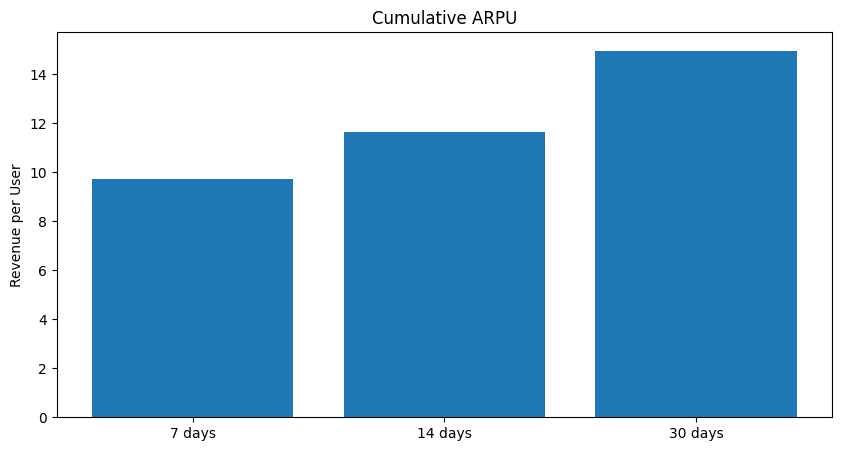

In [319]:
plt.figure(figsize=(10, 5))
plt.bar(['7 days', '14 days', '30 days'], [arpu_7, arpu_14, arpu_30])
plt.title('Cumulative ARPU')
plt.ylabel('Revenue per User')
plt.show()

#### 4.	Рассчитывание фактического CPI 
CPI (Cost Per Install) - это метрика, которая показывает среднюю стоимость привлечения одной установки приложения или программы. 

In [349]:
# вычисление и вывод CPI
ad_budget['CPI'] = ad_budget['Spend, USD'] / ad_budget['Installs']
print("CPI (стоимость привлечения клиента):")
print(ad_budget['CPI'])

CPI (стоимость привлечения клиента):
0    0.009476
1    0.368797
2    0.020708
3    0.428015
4    0.015478
5    1.438554
6    0.533882
7    0.269407
8    0.062046
Name: CPI, dtype: float64


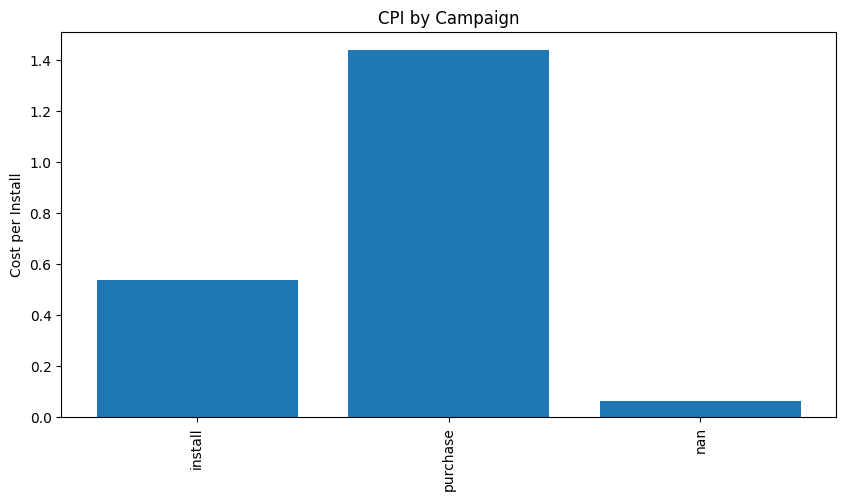

In [321]:
# Визуализация
plt.figure(figsize=(10, 5))
plt.bar(ad_budget['Campaign_type'].astype(str), ad_budget['CPI'])  # Преобразуем значения в строковый тип
plt.title('CPI by Campaign')
plt.ylabel('Cost per Install')
plt.xticks(rotation=90)
plt.show()

#### 5. Дополнительные метрики
##### 5.1. 
CVR (Conversion Rate) - это показатель, который измеряет процентное соотношение пользователей, совершивших желаемое действие к общему числу пользователей. Например, покупку, регистрацию, подписку. 

Здесь мы вычисляем конверсию регистрации в покупку на основе данных о регистрациях и платежах.\
Здесь видим, что из общего числа пользователей, зарегистрировавшихся в системе, 64.37% совершили покупку.                                             Этот результат указывает на хорошую эффективность процесса превращения регистраций в реальные покупки.

In [427]:
total_registrations = registrations['account_id'].nunique()
users_with_payments = payments['account_id'].nunique()
cvr = (users_with_payments / total_registrations) * 100
print("Конверсия регистрации в покупку (CVR): {:.2f}%".format(cvr))

Конверсия регистрации в покупку (CVR): 64.37%


##### 5.2. 
CAC (Customer Acquisition Cost) - это метрика, которая измеряет среднюю стоимость привлечения нового клиента для компании. 

Этот код вычисляет затраты на привлечение клиентов на основе данных о рекламном бюджете и количестве новых клиентов.\
Результат означает, что привлечение одного нового клиента обходится компании в среднем 4 цента. Соответственно что низкий CAC свидетельствует о эффективности маркетинга и рекламного бюджета.

In [428]:
total_marketing_costs = ad_budget['Spend, USD'].sum()
new_customers = registrations['account_id'].nunique()
cac = total_marketing_costs / new_customers

print("Затраты на привлечение клиентов (CAC): {:.2f} USD".format(cac))

Затраты на привлечение клиентов (CAC): 0.04 USD


##### 5.3.
Уровень вовлеченности (engagement rate) - это метрика, которая показывает, насколько активно пользователи взаимодействуют с продуктом или платформой.

Здесь вычисляем(engagement rate) на основе данных о количестве установок и активных пользователей, совершивших платежи.  
И в результате видим что 89.48% пользователей проявляют активность или взаимодействуют с продуктом.

In [429]:
total_installs = ad_budget['Installs'].sum()
active_users = payments['account_id'].nunique()
engagement_rate = (active_users / total_installs) * 100

print(f'Уровень вовлеченности: {engagement_rate}%')

Уровень вовлеченности: 89.477623577109%
